In [1]:
import os
# variable de entorno JAVA_HOME, en este caso para windows (en windows la diagonal es \\ en linux y mac es /)
#os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk1.8.0_241"

In [ ]:
#extraccion de caracteristicas  de un texto 

In [ ]:
# en caso de usar la version descargada de spark, agregar la ruta de la biblioteca de python que incluye
# si se usa la instalacion local, dejar comentadas estas lineas
# import sys
# sys.path.append("/home/octavio.renteria/spark/python")

In [2]:
# si todo esta bien instalado, esta linea no deberia causar problemas
import pyspark

In [3]:
# crear el contexto de spark

conf = pyspark.SparkConf()
conf.set('spark.executor.cores', '4')
conf.set('spark.cores.max', '4')
conf.set('spark.executor.memory', '4g')


sc = pyspark.SparkContext(master="local",appName="MyApp",conf=conf)


In [4]:
# crear sesion SQL y cargar nuestros datos
sqlContext= pyspark.sql.SparkSession(sc)
input_data = sqlContext.read.json("tesis.json")
input_data.printSchema()

root
 |-- index: long (nullable = true)
 |-- localización: string (nullable = true)
 |-- precedentes: string (nullable = true)
 |-- registro: string (nullable = true)
 |-- rubro: string (nullable = true)
 |-- tesis: string (nullable = true)
 |-- texto: string (nullable = true)



In [6]:
# generar una vista
input_data.createOrReplaceTempView("documentos")
input_data.show()

+-----+--------------------+--------------------+--------+--------------------+--------------------+--------------------+
|index|        localización|         precedentes|registro|               rubro|               tesis|               texto|
+-----+--------------------+--------------------+--------+--------------------+--------------------+--------------------+
|    0| [TA]; 9a. Época;...| .cs7CED571B{text...|  165307| CONSEJO DE LA JU...|Tesis aislada P. ...| Conforme a los a...|
|    1| [TA]; 9a. Época;...| Controversia con...|  177700| AUDITORÍA SUPERI...|Tesis aislada P. ...| El artículo 35, ...|
|    2| [TA]; 9a. Época;...| .cs8004C8AF{text...|  163131| EMPRESARIAL A TA...|Tesis aislada P. ...| En materia del i...|
|    3| [J]; 9a. Época; ...| Acción de incons...|  185694| PARTIDOS POLÍTIC...|Jurisprudencia P....| Al establecer el...|
|    4| [TA]; 9a. Época;...| Amparo en revisi...|  191123| SEGURIDAD SOCIAL...|Tesis aislada P. ...| El artículo 183 ...|
|    5| [J]; 9a. Época; 

In [5]:
pwd

'/home/nacho/Documents/Escuela_Met_Num_CIMAT'

In [11]:
# Extraer los datos a utilizar, realmente solo la columna texto es lo que usamos
result = sqlContext.sql("SELECT `registro`,rubro,texto from documentos")
result.show(5)

+--------+--------------------+--------------------+
|registro|               rubro|               texto|
+--------+--------------------+--------------------+
|  165307| CONSEJO DE LA JU...| Conforme a los a...|
|  177700| AUDITORÍA SUPERI...| El artículo 35, ...|
|  163131| EMPRESARIAL A TA...| En materia del i...|
|  185694| PARTIDOS POLÍTIC...| Al establecer el...|
|  191123| SEGURIDAD SOCIAL...| El artículo 183 ...|
+--------+--------------------+--------------------+
only showing top 5 rows



In [12]:
# Filtrar la columna texto de comas y puntos
import pyspark.sql.functions as F
result = result.withColumn('texto', F.regexp_replace('texto', ',|\.', ' '))
result.show(1,True)

+--------+--------------------+--------------------+
|registro|               rubro|               texto|
+--------+--------------------+--------------------+
|  165307| CONSEJO DE LA JU...| Conforme a los a...|
+--------+--------------------+--------------------+
only showing top 1 row



In [13]:
# Importar las clases relevantes de MLLib para nuestro caso.
from pyspark.ml.feature import Tokenizer, IDF, StopWordsRemover, CountVectorizer


In [14]:
# toquenizar
tokenizer = Tokenizer(inputCol="texto", outputCol="words")
result = tokenizer.transform(result)
result.show(1)

+--------+--------------------+--------------------+--------------------+
|registro|               rubro|               texto|               words|
+--------+--------------------+--------------------+--------------------+
|  165307| CONSEJO DE LA JU...| Conforme a los a...|[, conforme, a, l...|
+--------+--------------------+--------------------+--------------------+
only showing top 1 row



In [15]:
# filtrar
remover = StopWordsRemover(inputCol="words", outputCol="filtered" ,stopWords=StopWordsRemover.loadDefaultStopWords("spanish"))
result = remover.transform(result)
result.show(1)

+--------+--------------------+--------------------+--------------------+--------------------+
|registro|               rubro|               texto|               words|            filtered|
+--------+--------------------+--------------------+--------------------+--------------------+
|  165307| CONSEJO DE LA JU...| Conforme a los a...|[, conforme, a, l...|[, conforme, artí...|
+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [16]:
# vectorizar
vectorizer = CountVectorizer(inputCol="filtered", outputCol="vectorized")
vectorizer_model = vectorizer.fit(result)
result = vectorizer_model.transform(result)
result.show(1)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|registro|               rubro|               texto|               words|            filtered|          vectorized|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  165307| CONSEJO DE LA JU...| Conforme a los a...|[, conforme, a, l...|[, conforme, artí...|(18277,[0,3,5,7,9...|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [17]:
# normalizar
idf = IDF(inputCol="vectorized", outputCol="idf")
idf_model = idf.fit(result)
result = idf_model.transform(result)
result.show(1, True)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|registro|               rubro|               texto|               words|            filtered|          vectorized|                 idf|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  165307| CONSEJO DE LA JU...| Conforme a los a...|[, conforme, a, l...|[, conforme, artí...|(18277,[0,3,5,7,9...|(18277,[0,3,5,7,9...|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [20]:
# convertir columna de DataFrame a distributed RowMatrix
#tipo de dato matrix y vectir
from pyspark.mllib.linalg.distributed import RowMatrix 
from pyspark.mllib.linalg import Vectors
#mapea todas las operaciones, cada renglon se le hace una
#operacion de vectores tipo disperso, con tamaño, indices y valores
data = result.select("idf").rdd.map(lambda row: Vectors.sparse(row.idf.size, row.idf.indices, row.idf.values ) )
mat = RowMatrix(data)
type(mat)

pyspark.mllib.linalg.distributed.RowMatrix

In [21]:
type(data)

pyspark.rdd.PipelinedRDD

In [22]:
# reducir matriz a 100 columnas con SVD (este paso es lento por falta de configuración en spark)
svd = mat.computeSVD(100, computeU=True)

# realmente solo usamos la matriz U
U = svd.U
s = svd.s
V = svd.V  

In [26]:
# imprimir los registros con la palabra clave que me interesa para ecojer un documento (nos interesa el id del documento)
sql_query = sqlContext.sql("select `registro`,index as id, rubro from documentos").where( F.col("texto").contains('matrimonio') ).show(5,False)

+--------+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|registro|id |rubro                                                                                                                                                                                                                                                                                                   |
+--------+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|161266  |253| MATRIMONIO. LA EXISTENCIA DE DIVERSAS FORMAS DE R

In [28]:
# elegi el id 253, que es el documento 253 en el DataFrame o renglon 253 en la matriz U
id_target = 253

# las matrices distribuidas no son idexables (no funcionan con indices de corchete [] )
# por lo que hay que agregarles indice a cada fila

vectors = U.rows.zipWithIndex()

In [29]:
# extraemos el vector de la matriz U que corresponde al documento que nos iteresa
target = vectors.filter(lambda x:x[1]==id_target ).map(lambda x:x[0].toArray()).collect()
target

[array([-0.01257516,  0.00050718, -0.00234124,  0.00820494,  0.00283577,
         0.005696  ,  0.00365051,  0.00714535, -0.01379665,  0.00486279,
         0.00217664, -0.01694147,  0.01243483,  0.00826984,  0.01204578,
        -0.00436863, -0.01632994, -0.00671331, -0.0048124 ,  0.00996589,
         0.00419973, -0.00353273,  0.00162243,  0.00226286, -0.01749173,
        -0.00264649,  0.00215552, -0.00017876,  0.00271186, -0.01108926,
         0.00011832, -0.0069087 , -0.00167477, -0.00562037, -0.00198317,
         0.01484107, -0.01255471, -0.00440132,  0.0028022 , -0.00299496,
         0.00730538,  0.00301517,  0.00342917,  0.0091419 , -0.01607095,
        -0.01713467,  0.01258195,  0.00091441, -0.00424588,  0.00412737,
         0.00698667,  0.003653  ,  0.01222259, -0.01024554, -0.00340114,
         0.01009589,  0.0074709 ,  0.00349203,  0.00101443,  0.00254845,
        -0.00183562, -0.01016375, -0.01096922,  0.02009368,  0.01524471,
        -0.01516648,  0.00639519, -0.0238666 , -0.0

In [32]:
#map: haz esta operacion es todas las filas, y se paraleliza el proceso
# calcular la distancia entre este vector contra el resto
from scipy.spatial.distance import cosine
import numpy as np

distances = vectors.map(lambda x:  cosine(target[0], x[0].toArray()) ).collect()
# se ordenan las distancias de menor a mayor
distances = np.array(distances)
# se usan los índices que son relativos a los ids de los registros
idx = np.argsort(distances)
idx

array([ 253, 1635,  878, ...,  574, 1504, 2484])

In [34]:
# aqui se extraen los documentos cuyo id este entre el top 5, luego se agrega la distancia a cada documento
rows = sqlContext.sql(
        "select `registro`,index as id, texto from documentos"
    ).rdd.filter(
        lambda x: x.id in idx[:5]
    ).map(
        lambda x: (distances[x.id], x.registro, x.texto) 
    ).collect()

In [35]:
# Finalmente ordenar los datos bajados por distancia e imprimirlos
rows = sorted(rows, key = lambda x: x[0])
for row in rows:
    print(row,'\n')

(0.0, '161266', ' La evolución en el reconocimiento de los derechos de las personas homosexuales y la protección jurídica de sus uniones, se ha reflejado en la implementación de diversas normas y acciones, entre las que se encuentra la aprobación, en diversos países y en el propio Distrito Federal, de leyes que regulan las llamadas “sociedades de convivencia” o “pactos de solidaridad”, para reconocer y proteger las uniones de hecho de personas del mismo sexo. No obstante, si bien es cierto que a través de estas figuras se consigue una cierta paridad entre aquellas uniones y el matrimonio, también lo es que tales legislaciones lo equiparan, en lo general, al concubinato, sin que logren alcanzar el mismo reconocimiento y protección jurídica de los derechos y obligaciones que surgen del matrimonio civil. Así, la existencia previa de una figura legal distinta a la institución del matrimonio, no impide que se permita el acceso a este último, ya que no existe limitación constitucional alguna

## Esta parte es extra y muestra una simple implementacion con gráfos
Si calculamos la matriz de distancias entre todos los documentos (matriz de MxM), esta matriz la podemos interpretar como un grafo, en donde los documentos son los nodos y las distancias son las aristas que definen la relación entre documentos, sería un grafo con todos los nodos conectados contra todos. Si usamos esta representación podemos aplicar algoritmos de grafos a nuestros documentos.<br>
El siguiente ejemplo muestra una simple extracción de subgrafos, si a la matriz de distancias le aplicamos una restricción de distancia mínima para quitar relaciones "inecesarias", es muy probable que empiecen a generarse "islas" de nodos, conectados entre si pero desconectados del resto del grafo. Estas islas podemos interpretarlas como documentos fuertemente relacionados.
<br><br>
Empezamos por generar nuestra matriz de distancias:

In [36]:
from scipy.spatial.distance import cdist

M = U.rows.collect()
M = np.array(M)
D = cdist(M, M, metric='cosine')
idx=np.argsort(D,axis=1)

### Extraer los pares de nodos que cumplan con una distancia mínima

In [38]:
max_dist = 0.15
pairs = np.argwhere(D<max_dist)

### Crear un grafo con estos pares

In [39]:
import networkx as nx
G = nx.Graph()
#G.add_weighted_edges_from(pairs)
G.add_edges_from(pairs)

### A este grafo extraer los subgrafos desconectados

In [40]:
comp = [list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("subgraps",len(comp))

subgraps 2288


### La lista esta ordenada mayor a menor tamaño de grafo, elegir uno de los subgráfos

In [41]:
nodes = comp[0]
sG = G.subgraph(nodes)

### Extraer el titulo del documento de acuerdo al id de los nodos del subgráfo

In [43]:
sub = sqlContext.sql(
        "select `registro`,index as id, rubro from documentos"
    ).rdd.filter(
        lambda x: x.id in nodes
    ).map(
        lambda x: x.rubro).collect()

### Dibujar el subgrafo

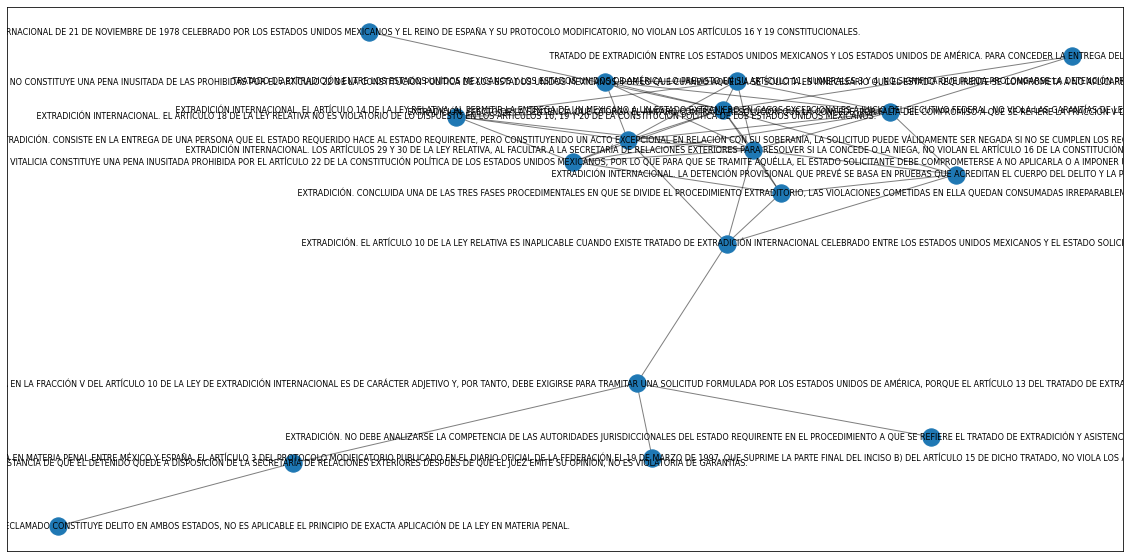

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
pos = nx.spring_layout(sG)
nx.draw_networkx_nodes(sG,pos=pos)
a=nx.draw_networkx_labels(sG,pos=pos ,labels={nodes[i]:j for i,j in enumerate(sub)}, font_size=8 )
nx.draw_networkx_edges(sG, pos=pos, width=1.0, alpha=0.5)